In [2]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2
import json
import pprint
import boto
import pickle

In [3]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [4]:
import anno_prep.extract_boxes as box_ext

# Write temp annotation files (for the annotation tool)

In [78]:
image_dir = './images/' 
anno_dir = './baseAnnotations/'
img_dir = '/Users/schwenk/wrk/vision/datasets/shining3/images/'

In [57]:
images_to_annotate = pd.read_csv('./list_to_annotate.txt', header=None)
images_to_annotate.columns= ['image_name']
images_to_annotate_list = images_to_annotate['image_name'].tolist()

In [58]:
zip_files = !ls baseAnnotations/

In [80]:
in1 = [im.split('.')[0] for im in images_to_annotate_list]
in2 = [im.split('.')[0] for im in zip_files]
# print(len(in1), len(in2))

In [60]:
for image_file in images_to_annotate_list:
    box_ext.write_annotations_for_tool(image_file, anno_dir)

In [61]:
base_anno_dir = 'anno_w_infrastructure/'
new_anno_dir = 'anno_w_dim/'
img_d_l = box_ext.add_anno_img_dim(img_dir, images_to_annotate_list, base_anno_dir, new_anno_dir)

In [62]:
with open('dim_lookup.pkl', 'w') as f:
    pickle.dump(img_d_l, f)

# looking at box counts over the dataset

In [63]:
box_n_counts = {}
for image_file in images_to_annotate_list:
    page_anno = box_ext.load_local_annotation(image_file + '.json', 'baseAnnotations/')
    anno_count = 0
    for anno_type, annotations in page_anno.items():
        for box_id, box_val in annotations.items():
            if anno_type in ['blobs', 'arrows', 'backgroundBlobs', 'text']:
                anno_count += len(box_val)
    box_n_counts[image_file] = anno_count

In [77]:
small_pages = [k for k, v in box_n_counts.items() if v < 40]
with open('small_pages.pkl', 'w') as f:
    pickle.dump(small_pages, f)

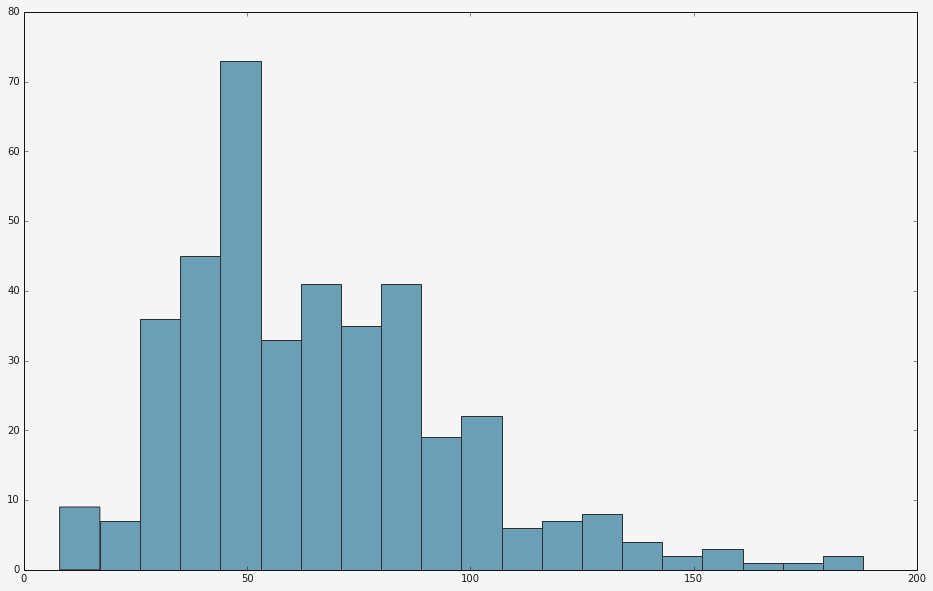

In [72]:
_ = pd.Series(box_n_counts).hist(bins = 20, grid=False)

# investigating images with flipped text

In [37]:
bad_images = set()
for image_file in images_to_annotate_list:
    page_anno = box_ext.load_local_annotation(image_file + '.json', 'baseAnnotations/')
    x_bound, y_bound = img_d_l[image_file]
    for anno_type, annotations in page_anno.items():
        for box_id, box_val in annotations.items():
            if anno_type in ['text']:
                if box_val['rectangle'][1][0] > x_bound or box_val['rectangle'][1][1] > y_bound:
                    bad_images.add(image_file)

In [42]:
bad_image_list = sorted(list(bad_images))

In [55]:
%page bad_image_list

In [47]:
with open ('bad_images.pkl', 'w') as f:
    pickle.dump(bad_image_list, f)

# End

In [23]:
s3_con = boto.connect_s3(aws_access_key_id=ai2_aws.access_key, aws_secret_access_key=ai2_aws.access_secret_key)

In [31]:
turk_data_tl_b = s3_con.get_bucket('ai2-vision-turk-data')

In [158]:
not_in_zip =  set(in1).difference(set(in2))

not_in_txt_list = set(in2).difference(set(in1))

not_in_zip

not_in_txt_list

with open (anno_dir + test_anno_file) as f:
    test_anno = json.load(f)

print(test_anno.keys())

# pprint.pprint(test_anno['backgroundBlobs'])

pprint.pprint(test_anno['blobs'])

box_ext.create_anno_for_tool(test_anno)